# ANALYSIS TO FIND BEST CHINESE RESTAURANTS IN INDIA.

### Importing necessary libraries.

In [20]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
# !pip install geocoder
import geocoder
import os
# !pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


### Function to get the geolocation of an address.

In [223]:
def geo_location(address):
    # get geo location of address
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        return latitude,longitude
    except:
        pass

### Function to interact with Foursquare API to get top 100 venues within a radius of 50000 meters for a given lattitude and longitude.
### Below function will return us venue id, venue name, and category.

In [273]:
def get_venues(lat,lng):
    
    #set variables
    radius=50000
    LIMIT=100
    CLIENT_ID = 'JXF12LQXS5KZGFAJA2H0EFCIFEGBWJIWX3ZVQIYNJ3OOXWO0'     # Foursquare ID
    CLIENT_SECRET = 'YMV5XNYVCB45Z4JUSGJM3YUWXXETGBMMOMNVEMXYJGAFJNP1' # Foursquare Secret
    VERSION = '20191225' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    try:
        for row in venue_data:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
    except KeyError:
        pass
    
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking

In [274]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'JXF12LQXS5KZGFAJA2H0EFCIFEGBWJIWX3ZVQIYNJ3OOXWO0' # your Foursquare ID
    CLIENT_SECRET = 'YMV5XNYVCB45Z4JUSGJM3YUWXXETGBMMOMNVEMXYJGAFJNP1' # your Foursquare Secret
    VERSION = '20191225' # Foursquare API version
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Function to get India Data  containg State, city, Latitude and Longitude.

In [9]:
def get_india_data():
    url='https://raw.githubusercontent.com/hemangmonga/Coursera_Capstone.-/master/in.json'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp
    
    # define the dataframe columns
    column_names = ['State', 'city', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    india_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        State = data['admin'] 
        city = data['city']
        neighborhood_lat = data['lat']
        neighborhood_lon = data['lng']
    
        india_data = india_data.append({'State': State,
                                          'city': city,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
        
        
    return india_data

### And Cleaning the Data.

In [10]:
df = get_india_data()

for i in range(0,len(df.city)):
    for j in df.city[i]:
        if j == 'ā':
            df.city[i] = df.city[i].replace('ā','a')
            
        elif j == 'Ā':
            df.city[i] = df.city[i].replace('Ā','A')
       
        elif j == 'ī':
            df.city[i] = df.city[i].replace('ī','i')
            
        elif j == 'ū':
            df.city[i] = df.city[i].replace('ū','u')
            
for i in range(0,len(df.State)):
    for j in df.State[i]:
        if j == 'ā':
            df.State[i] = df.State[i].replace('ā','a')
            
        elif j == 'Ā':
            df.State[i] = df.State[i].replace('Ā','A')
       
        elif j == 'ī':
            df.State[i] = df.State[i].replace('ī','i')
            
        elif j == 'ū':
            df.State[i] = df.State[i].replace('ū','u')
            
df.head()

,State,city,Latitude,Longitude
0,Maharashtra,Mumbai,18.987807,72.836447
1,Delhi,Delhi,28.651952,77.231495
2,West Bengal,Kolkata,22.562627,88.363044
3,Tamil Nadu,Chennai,13.084622,80.248357
4,Karnataka,Bengaluru,12.977063,77.587106


In [11]:
df.shape

(212, 4)

###  Plotting a Graph to see No. of Cities in each State.

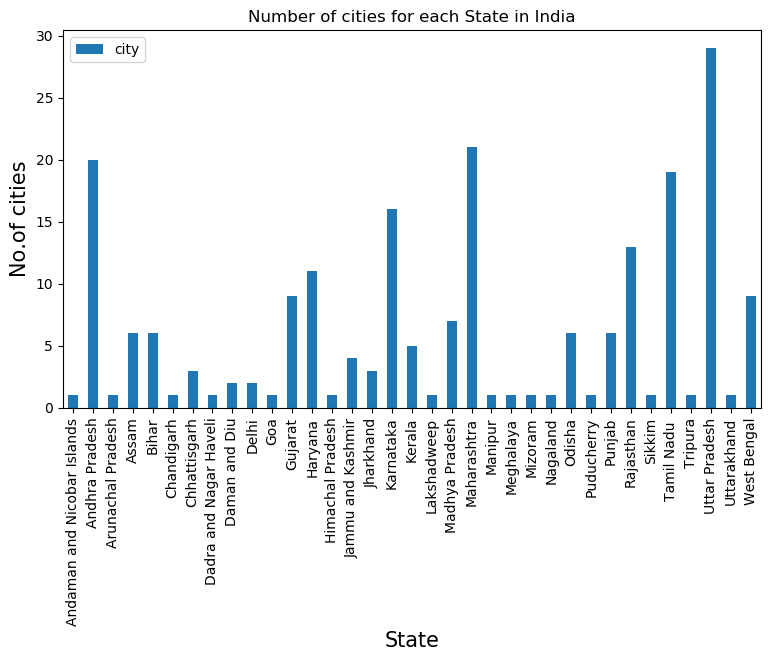

In [293]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of cities for each State in India')
#On x-axis
plt.xlabel('State', fontsize = 15)
#On y-axis
plt.ylabel('No.of cities', fontsize=15)
#giving a bar plot
df.groupby('State')['city'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Calling Functions to see no. of Chinese Restaurants in Each City.

In [13]:
column_names=['State', 'city', 'ID','Name']
Chinese_rest=pd.DataFrame(columns=column_names)
count=1
for row in df.values.tolist():
    State, city, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(df),')','Chinese Resturants in '+city+', '+State+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        Chinese_rest = Chinese_rest.append({'State': State,
                                                'city': city, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 212 ) Chinese Resturants in Mumbai, Maharashtra:1
( 2 / 212 ) Chinese Resturants in Delhi, Delhi:1
( 3 / 212 ) Chinese Resturants in Kolkata, West Bengal:8
( 4 / 212 ) Chinese Resturants in Chennai, Tamil Nadu :2
( 5 / 212 ) Chinese Resturants in Bengaluru, Karnataka:0
( 6 / 212 ) Chinese Resturants in Hyderabad, Andhra Pradesh:1
( 7 / 212 ) Chinese Resturants in Ahmadabad, Gujarat:1
( 8 / 212 ) Chinese Resturants in Haora, West Bengal:8
( 9 / 212 ) Chinese Resturants in Pune, Maharashtra:0
( 10 / 212 ) Chinese Resturants in Surat, Gujarat:3
( 11 / 212 ) Chinese Resturants in Mardanpur, Uttar Pradesh:0
( 12 / 212 ) Chinese Resturants in Rampura, Rajasthan:0
( 13 / 212 ) Chinese Resturants in Lucknow, Uttar Pradesh:0
( 14 / 212 ) Chinese Resturants in Nara, Maharashtra:1
( 15 / 212 ) Chinese Resturants in Patna, Bihar:1
( 16 / 212 ) Chinese Resturants in Indore, Madhya Pradesh:1
( 17 / 212 ) Chinese Resturants in Vadodara, Gujarat:0
( 18 / 212 ) Chinese Resturants in Bhopal, Madhy

In [14]:
Chinese_rest.head()

,State,city,ID,Name
0,Maharashtra,Mumbai,4b5dc6e6f964a520166b29e3,Ming Yang
1,Delhi,Delhi,4ed0f96e6c2510ace194f2f7,Hawkers
2,West Bengal,Kolkata,4dfa2b8aae60f95f8225b9c9,Big Boss
3,West Bengal,Kolkata,4cdea62ef8cdb1f7a35e8c12,Golden Joy
4,West Bengal,Kolkata,534fda5e498e8696570687b8,Yauatcha


In [15]:
Chinese_rest.shape

(77, 4)

### Plotting a graph for No. of Chinese Restaurants in each state of India.

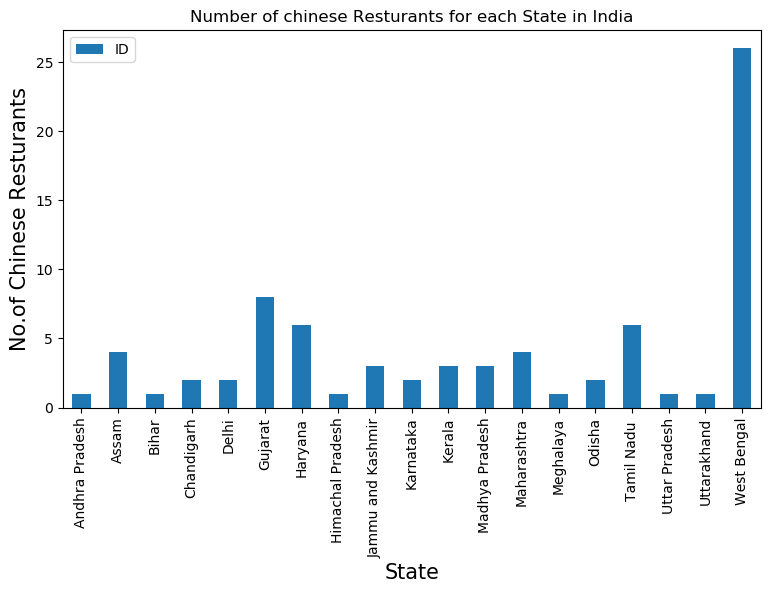

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of chinese Resturants for each State in India')
#On x-axis
plt.xlabel('State', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
Chinese_rest.groupby('State')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Plotting A Graph for 5 cities with highest no. of Chinese Restaurants.

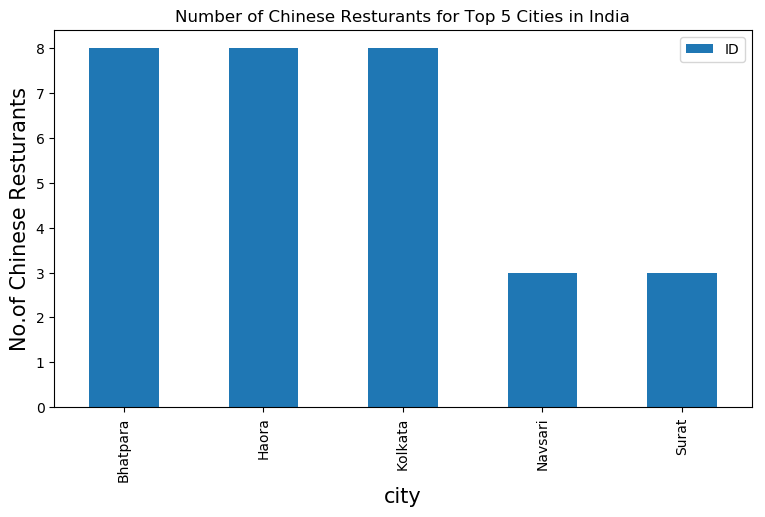

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for Top 5 Cities in India')
#On x-axis
plt.xlabel('City', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
Chinese_rest.groupby('city')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Best Chinese Restaurants in Kolkata.

In [18]:
Chinese_rest[Chinese_rest.city == 'Kolkata']

,State,city,ID,Name
2,West Bengal,Kolkata,4dfa2b8aae60f95f8225b9c9,Big Boss
3,West Bengal,Kolkata,4cdea62ef8cdb1f7a35e8c12,Golden Joy
4,West Bengal,Kolkata,534fda5e498e8696570687b8,Yauatcha
5,West Bengal,Kolkata,4d19f40dbb488cfa6628c1d4,Beijing Restaurant
6,West Bengal,Kolkata,4d7b9c9e8f89224b06c89326,Red Hot Chilli Pepper
7,West Bengal,Kolkata,4bbcaf18f57ba593d810adb9,Chinoiserie
8,West Bengal,Kolkata,4c0651d9761ac9b60ab92074,Mainland China
9,West Bengal,Kolkata,4bded98ffe0e62b52eff0506,O2 Hotel Kolkata


In [111]:
#prepare city list that contains Chinese resturants
column_names=['State', 'city', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats=pd.DataFrame(columns=column_names)
count=1


for row in Chinese_rest.values.tolist():
    State,city,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except:                                                                                                
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Chinese_rest),')','processed')
    chinese_rest_stats = chinese_rest_stats.append({'State': State,
                                                'city': city, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID      Name  Likes  Rating  Tips
0  4dfa2b8aae60f95f8225b9c9  Big Boss     22     8.5     8
( 1 / 77 ) processed


In [296]:
rating_df = chinese_rest_stats
# rating_df

In [118]:
rating_df.head()

,State,city,ID,Name,Likes,Rating,Tips
0,Odisha,Cuttack,4da84de37aba67f9d9619c29,Mainland China,10,7.8,7
1,West Bengal,Shiliguri,0,0,0,0.0,0
2,Madhya Pradesh,Ujjain,4f235911e4b01b0c5e5b28ff,Chopstick City,11,8.4,4
3,West Bengal,Bhatpara,4dfa2b8aae60f95f8225b9c9,Big Boss,22,8.5,8
4,West Bengal,Bhatpara,4cdea62ef8cdb1f7a35e8c12,Golden Joy,20,8.4,12


In [119]:
rating_df.shape

(77, 7)

### Saving this list of Best Chinese Restaurants in a csv File.

In [120]:
rating_df.to_csv('Chinese_rest_stats.csv', index = False)

In [122]:
rating_df = pd.read_csv('Chinese_rest_stats.csv')
rating_df

,State,city,ID,Name,Likes,Rating,Tips
0,Odisha,Cuttack,4da84de37aba67f9d9619c29,Mainland China,10,7.8,7
1,West Bengal,Shiliguri,0,0,0,0.0,0
2,Madhya Pradesh,Ujjain,4f235911e4b01b0c5e5b28ff,Chopstick City,11,8.4,4
3,West Bengal,Bhatpara,4dfa2b8aae60f95f8225b9c9,Big Boss,22,8.5,8
4,West Bengal,Bhatpara,4cdea62ef8cdb1f7a35e8c12,Golden Joy,20,8.4,12
5,West Bengal,Bhatpara,4d19f40dbb488cfa6628c1d4,Beijing Restaurant,20,8.3,9
6,West Bengal,Bhatpara,534fda5e498e8696570687b8,Yauatcha,15,8.3,5
7,West Bengal,Bhatpara,4d7b9c9e8f89224b06c89326,Red Hot Chilli Pepper,15,8.3,4
8,West Bengal,Bhatpara,4bbcaf18f57ba593d810adb9,Chinoiserie,7,7.9,6
9,West Bengal,Bhatpara,4c0651d9761ac9b60ab92074,Mainland China,41,8.0,17


In [124]:
rating_df.dtypes

State      object
city       object
ID         object
Name       object
Likes       int64
Rating    float64
Tips        int64
dtype: object

In [125]:
# Resturant with maximum Likes
rating_df.iloc[rating_df['Likes'].idxmax()]

State                  Uttarakhand
city                     Dehra Dun
ID        4be57ff9d4f7c9b6ff712520
Name       Kalsang Friend's Corner
Likes                           54
Rating                         8.8
Tips                            27
Name: 74, dtype: object

In [127]:
# Resturant with maximum Rating
rating_df.iloc[rating_df['Rating'].idxmax()]

State                  Maharashtra
city                        Mumbai
ID        4b5dc6e6f964a520166b29e3
Name                     Ming Yang
Likes                           28
Rating                         8.9
Tips                            13
Name: 33, dtype: object

In [128]:
# Resturant with maximum Tips
rating_df.iloc[rating_df['Tips'].idxmax()]

State                  Uttarakhand
city                     Dehra Dun
ID        4be57ff9d4f7c9b6ff712520
Name       Kalsang Friend's Corner
Likes                           54
Rating                         8.8
Tips                            27
Name: 74, dtype: object

### List of Average Rating in all the cities.

In [129]:
city_stats=rating_df.groupby('city',as_index=False).mean()[['city','Rating']]
city_stats.columns=['city','Average Rating']

In [131]:
city_stats.sort_values(['Average Rating'],ascending=False).head(10)

,city,Average Rating
27,Mumbai,8.9
24,Kalyan,8.9
6,Bhiwandi,8.9
12,Dehra Dun,8.8
21,Hyderabad,8.5
32,New Delhi,8.4
18,Gurgaon,8.4
17,Ghaziabad,8.4
15,Faridabad,8.4
13,Delhi,8.4


### List of Average Rating is all the States.

In [133]:
State_stats=rating_df.groupby('State',as_index=False).mean()[['State','Rating']]
State_stats.columns=['State','Average Rating']

In [135]:
State_stats.sort_values(['Average Rating'],ascending=False).head(10)

,State,Average Rating
17,Uttarakhand,8.800000
0,Andhra Pradesh,8.500000
12,Maharashtra,8.475000
4,Delhi,8.400000
16,Uttar Pradesh,8.400000
11,Madhya Pradesh,8.133333
6,Haryana,8.100000
3,Chandigarh,7.950000
5,Gujarat,7.925000
14,Odisha,7.800000


### Plotting a graph for Average Rating of Chinese Restaurants for Each State.

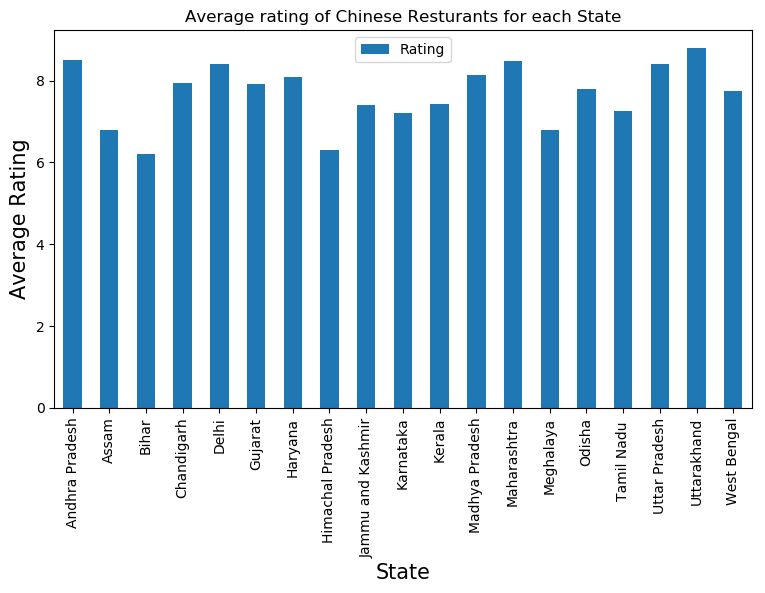

In [136]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each State')
#On x-axis
plt.xlabel('State', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
rating_df.groupby('State').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### Selecting Cities With Average Rating > 8.5 

In [189]:
city_stats_top=city_stats[city_stats['Average Rating']>=8.5]
city_stats_top.index = [0,1,2,3,4]
city_stats_top

,city,Average Rating
0,Bhiwandi,8.9
1,Dehra Dun,8.8
2,Hyderabad,8.5
3,Kalyan,8.9
4,Mumbai,8.9


In [190]:
# Merging with df to get Latitude and longitude for each City.
city_stats_top=pd.merge(city_stats_top,df, on='city')

In [187]:
# latitude = pd.Series([])
# longitude = pd.Series([])
# for i in range(0, len(city_stats_top)):
#     latitude[i] = geo_location(city_stats_top.city[i])[0]
#     longitude[i] = geo_location(city_stats_top.city[i])[1]

# city_stats_top.insert(2, "Latitude", latitude) 
# city_stats_top.insert(3, "Longitude", longitude) 

In [195]:
city_stats_top = city_stats_top[['State', 'city', 'Latitude', 'Longitude', 'Average Rating']]
city_stats_top

,State,city,Latitude,Longitude,Average Rating
0,Maharashtra,Bhiwandi,19.300229,73.058813,8.9
1,Uttarakhand,Dehra Dun,30.324427,78.033922,8.8
2,Andhra Pradesh,Hyderabad,17.384052,78.456355,8.5
3,Maharashtra,Kalyan,19.243703,73.135537,8.9
4,Maharashtra,Mumbai,18.987807,72.836447,8.9


In [192]:
#INDIA-Map.
india_map = folium.Map(location=geo_location('India'), zoom_start=6)

In [193]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in city_stats_top[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [199]:
city_stats_top['Label']=city_stats_top['city']+', '+city_stats_top['State']+'('+city_stats_top['Average Rating'].map(str)+')'
city_stats_top

,State,city,Latitude,Longitude,Average Rating,Label
0,Maharashtra,Bhiwandi,19.300229,73.058813,8.9,"Bhiwandi, Maharashtra(8.9)"
1,Uttarakhand,Dehra Dun,30.324427,78.033922,8.8,"Dehra Dun, Uttarakhand(8.8)"
2,Andhra Pradesh,Hyderabad,17.384052,78.456355,8.5,"Hyderabad, Andhra Pradesh(8.5)"
3,Maharashtra,Kalyan,19.243703,73.135537,8.9,"Kalyan, Maharashtra(8.9)"
4,Maharashtra,Mumbai,18.987807,72.836447,8.9,"Mumbai, Maharashtra(8.9)"


In [290]:
# add pop-up text to each marker on the map
for lat, lng, label in city_stats_top[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(india_map)        
# add incidents to map
india_map = india_map.add_child(incidents)
india_map.save('borough_rating.html')

In [291]:
india_map

### Function to get details of any category in any location.

In [294]:
def get_details(address, Place):
    Place_list = list()
    Category = pd.DataFrame(columns = ['ID', 'Name', 'Category'])

    # address = input('Enter Location:')
    # Place = input('Enter what you want to find:')

    lat = geo_location(address)[0]
    lng = geo_location(address)[1]
    venues = get_venues(lat,lng)

    for i in venues.Category:
            if(i.find(Place) != -1):
                Place_list.append(i)

    for i in range(0,len(Place_list)):
        Category = Category.append(venues[venues['Category'] == Place_list[i]])

    column_names=['ID','Name','Likes','Rating','Tips']
    Category_stats=pd.DataFrame(columns=column_names)
    count=1


    for row in Category[0:11].values.tolist():
        ID,Name,cat=row
        try:
            venue_details=get_venue_details(ID)
            id,name,likes,rating,tips=venue_details.values.tolist()[0]
        except IndexError:
            print('No data available for id=',ID)
            id,name,likes,rating,tips=[0]*5

        Category_stats = Category_stats.append({'ID': id,
                                                    'Name' : name,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips
                                                   }, ignore_index=True)
        count+=1

    return Category_stats

In [295]:
get_details('kandivali', 'Restaurant')

,ID,Name,Likes,Rating,Tips
0,4c42c88ed7fad13afaac09da,Indigo Delicatessen,90,8.5,54
1,51fa1f52ccdae6540ad807b4,Hard Rock Cafe Andheri,389,8.4,76
2,4d04fc8b30a58cfaead2a2e7,Mahesh Lunch Home,120,8.7,41
3,4d2ca96ec406721eb5bd96b6,Soul Fry,55,8.6,33
4,4eff27b1e5faf2869b1aba6f,Jai Jawan,25,8.3,17
5,4bfe4e1855539c7488d2bcf3,Jai Hind Lunch Home,23,8.9,5
6,4beaed8a415e20a130a6e5bb,Fareed Seekh Kebab,15,8.3,10
7,4b65a8ecf964a52043f82ae3,Urban Tadka,40,8.4,26
8,4be958699a54a593eaee0a11,Punjab Sweet House And Restaurant,41,8.9,27
9,4b5be651f964a520501c29e3,Vishwa Bharti,16,8.4,9


## CONCLUSION.
### 1.Following are the places in India where we can find great Chinese Restaurants:Bhiwandi (Maharashtra), Dehra Dun (Uttarkhand), Hyderabad (Andhra Pradesh), Kalyan (Maharashtra), Mumbai (Maharashtra)

### 2.Bhiwandi (Maharashtra) , Dehra Dun (Uttarkhand) and Hyderabad (Andhra Pradesh) are some locations in India for good Chinese Restaurants.

### 3.Andhra Pradesh and Uttarkhand have Potential Chinese Market.

### 4.Bihar ranks last in average rating of Chinese Restaurants.

### 5.Mumbai is the best place to stay if you love Chinese restaurants.